In [60]:
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls

/content
Cloning into 'Gradu'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 327 (delta 71), reused 43 (delta 43), pack-reused 232 (from 2)
Receiving objects: 100% (327/327), 45.72 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/Gradu
 chatti_RF.ipynb	       MSCI_XGBOOST.ipynb		    RF_Gradu.ipynb
 Fama_french_XGBOOST.ipynb     Regiimi_prediction.ipynb		   'RF REGIIMI HYVÄ TRAINING.ipynb'
'Financial turbulence.ipynb'   regime_prediction_famafrench.ipynb  'RF_regime (3).ipynb'
 FT_source.xlsx		       regime_prediction_msci.ipynb	    THE_ONE.xlsx
 Gradient_boost_malli.ipynb    regime_pred.txt


In [29]:
calc_drawdowns = True
drawdowns_from = 'Mkt-RF'
cluster_n = 2

DL = False
ML = True

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML
from sklearn.cluster import KMeans

In [31]:
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
excel_df = xls_file.parse("22.2.2025")

excel_df.columns = excel_df.columns.get_level_values(0)
excel_df['Date'] = pd.to_datetime(excel_df['Date'])
excel_df.sort_values('Date', inplace=True)

print("Headers in the 'returns non-log' sheet:")
print(excel_df.columns)

Headers in the 'returns non-log' sheet:
Index(['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'SMB-12A',
       'HML-12A', 'RMW-12A', 'CMA-12A', 'RSI-SMB', 'RSI-HML', 'RSI-RMW',
       'RSI-CMA', 'CPI', 'Cape', 'Treasury_10Y', 'Winning Factor', 'check',
       'NFCI', 'T10YFF', 'DGS1', 'DGS5', 'GARCH', 'Last_month'],
      dtype='object')


In [32]:
if calc_drawdowns:
    # Calculate the cumulative portfolio values using excel_df and the specified drawdowns_from column
    portfolio = (1 + excel_df[drawdowns_from]).cumprod()

    # Define a function to compute the maximum drawdown over a rolling window
    def max_dd(s):
        return (s / s.cummax() - 1).min()

    # Calculate the 3-month rolling drawdown using the portfolio series
    dd_series = portfolio.rolling(window=3, min_periods=3).apply(max_dd, raw=False)

    # Create a temporary DataFrame to store dates and the calculated drawdowns
    dd_temp = pd.DataFrame({
        'Date': excel_df['Date'],
        '3M_Max_Drawdown': dd_series
    })

    # Drop rows with missing drawdown data to ensure complete observations
    dd_temp = dd_temp.dropna()

    print("Drawdown calculation (temporary DataFrame):")
    print(dd_temp.head())


Drawdown calculation (temporary DataFrame):
        Date  3M_Max_Drawdown
2 1963-10-01        -0.015728
3 1963-11-01        -0.015728
4 1963-12-01        -0.008481
5 1964-01-01        -0.008481
6 1964-02-01         0.000000


In [33]:
# Fit KMeans clustering on the temporary DataFrame's '3M_Max_Drawdown' column
kmeans = KMeans(n_clusters=cluster_n, random_state=42)
dd_temp['DD_cluster'] = kmeans.fit_predict(dd_temp[['3M_Max_Drawdown']])

# Merge the cluster labels from dd_temp into excel_df by matching on the 'Date' column.
# This adds a new column 'DD_cluster' to excel_df.
excel_df = excel_df.merge(dd_temp[['Date', 'DD_cluster']], on='Date', how='left')

print("excel_df with DD_cluster added:")
from IPython.display import display, HTML
display(HTML(excel_df.head().to_html(index=False)))


excel_df with DD_cluster added:


Date,Mkt-RF,SMB,HML,RMW,CMA,RF,SMB-12A,HML-12A,RMW-12A,CMA-12A,RSI-SMB,RSI-HML,RSI-RMW,RSI-CMA,CPI,Cape,Treasury_10Y,Winning Factor,check,NFCI,T10YFF,DGS1,DGS5,GARCH,Last_month,DD_cluster
1963-08-01,-0.004027,-0.004313,-0.009794,0.005491,-0.013051,0.002643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.69,19.969232,4.00,RMW,1,NaN,0.52,3.59,3.93,0.004094,RSHC,NaN
1963-09-01,0.050801,-0.007409,0.016690,0.002689,-0.000824,0.002423,NaN,NaN,NaN,NaN,50.855086,51.525905,51.059536,50.000000,30.75,20.472638,4.08,HML,1,NaN,0.57,3.59,3.94,0.003689,HRCS,NaN
1963-10-01,-0.015728,-0.004244,0.000064,-0.005911,0.002676,0.002804,NaN,NaN,NaN,NaN,50.311665,49.889949,50.099010,49.924242,30.72,20.960360,4.11,CMA,0,NaN,0.65,3.68,4.01,0.005001,CHSR,1.0
1963-11-01,0.025101,-0.013001,0.000175,0.025746,-0.015377,0.002994,NaN,NaN,NaN,NaN,52.384292,50.151057,48.916117,50.187032,30.75,20.891345,4.12,RMW,0,NaN,0.58,3.74,3.99,0.004213,RHSC,1.0
1963-12-01,-0.008481,-0.010032,0.018485,-0.004858,0.021257,0.002703,NaN,NaN,NaN,NaN,48.692265,49.473684,51.188052,49.010198,30.78,20.720399,4.13,CMA,1,NaN,0.89,3.83,4.06,0.013948,CHRS,1.0


In [49]:

FEATURES = [
    # 'CPI',
    'Cape',
    # 'Treasury_10Y',
    'GARCH'
]

TRUE_REGIME = 'DD_cluster'
DATE = 'Date'

selected_columns =  [DATE] + [TRUE_REGIME] +FEATURES


In [50]:
missing = [col for col in selected_columns if col not in excel_df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

# Subset and drop rows with empty values
input_df = excel_df[selected_columns]
orig_rows = len(input_df)
input_df = input_df.dropna()
print(f"Original rows: {orig_rows}, Dropped rows: {orig_rows - len(input_df)}")
print(f"First obs: {input_df[DATE].min()}, Last obs: {input_df[DATE].max()}")

# Display as neat HTML table (adjust 'rows_to_show' as needed)
rows_to_show = 10
from IPython.display import display, HTML
display(HTML(input_df.head(rows_to_show).to_html(index=False)))

Original rows: 738, Dropped rows: 2
First obs: 1963-10-01 00:00:00, Last obs: 2025-01-01 00:00:00


Date,DD_cluster,Cape,GARCH
1963-10-01,1.0,20.960360,0.005001
1963-11-01,1.0,20.891345,0.004213
1963-12-01,1.0,20.720399,0.013948
1964-01-01,1.0,21.038599,0.003212
1964-02-01,1.0,21.627216,0.002518
1964-03-01,1.0,21.832671,0.002122
1964-04-01,1.0,22.167246,0.002052
1964-05-01,1.0,22.422192,0.003026
1964-06-01,1.0,22.574331,0.002220
1964-07-01,1.0,22.300288,0.002613


In [51]:
from tabulate import tabulate

# Calculate the number of observations for each regime in the data
regime_counts = input_df[TRUE_REGIME].value_counts().sort_index().reset_index()
regime_counts.columns = [TRUE_REGIME, 'Count']

print("Number of observations per regime:")
print(tabulate(regime_counts, headers='keys', tablefmt='psql', showindex=False))


Number of observations per regime:
+--------------+---------+
|   DD_cluster |   Count |
|--------------+---------|
|            0 |     144 |
|            1 |     592 |
+--------------+---------+


In [56]:
if ML == True:
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, confusion_matrix

    # Define predictors and target using the given column lists
    predictors = FEATURES
    target = TRUE_REGIME

    # Drop rows with missing values in predictors or target
    data = input_df.dropna(subset=predictors + [target]).reset_index(drop=True)
    X = data[predictors]
    y = data[target]
    # Also grab the DATE column for printing prediction timestamps
    dates = data[DATE]

    # Define the base models with high parameters, now including Gradient Boosting
    base_models = {
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        'SVC': SVC(probability=True, C=1000, kernel='rbf', gamma='scale'),
        'GaussianNB': GaussianNB(var_smoothing=1e-8)
    }

    # Define the meta-learner
    meta_learner = LogisticRegression(max_iter=1000, random_state=42)

    window_size = 60  # fixed window length once reached
    min_data_pct = 0.8  # start base model predictions when available data >= 80% of window_size
    base_threshold = int(window_size * min_data_pct)

    # Initialize dictionaries/lists to store rolling accuracies and meta weights
    rolling_accuracies_base = {name: [] for name in base_models}
    rolling_accuracies_meta = []
    meta_weights_list = []  # record meta-learner coefficients

    # Initialize expanding meta training set (meta features and outcomes)
    meta_train_features = []
    meta_train_targets = []

    # Initialize lists to store predictions for later use (for merging with Excel)
    predicted_dates = []
    predicted_regs = []

    print("Starting rolling window evaluation with stacking ensemble and expanding meta learner:")

    for i in range(len(X)):
        # Do not make any prediction until we have at least base_threshold observations
        if i < base_threshold:
            print(f"Skipping prediction for timestamp {dates.iloc[i]} "
                  f"(insufficient data: {i} observations, need {base_threshold}).")
            continue

        # For base models, if i is less than full window_size, use all data from start to i.
        # Once i >= window_size, use a fixed rolling window of size window_size.
        if i < window_size:
            X_train_window = X.iloc[:i]
            y_train_window = y.iloc[:i]
        else:
            X_train_window = X.iloc[i-window_size:i]
            y_train_window = y.iloc[i-window_size:i]

        X_test_window = X.iloc[[i]]
        y_test_window = y.iloc[[i]]
        test_date = dates.iloc[i]

        # --- Step 1: Generate meta features from base model predictions ---
        meta_features_test = np.zeros((1, len(base_models)))
        for j, (name, model) in enumerate(base_models.items()):
            model.fit(X_train_window, y_train_window)
            probs = model.predict_proba(X_test_window)
            if probs.shape[1] == 1:
                # Edge-case: model returns only one class probability
                y_pred_prob = 1.0 if model.classes_[0] == 1 else 0.0
            else:
                y_pred_prob = probs[0, 1]
            meta_features_test[0, j] = y_pred_prob

            # Record accuracy for each base model on this test observation
            y_pred = model.predict(X_test_window)[0]
            acc = accuracy_score(y_test_window, [y_pred])
            rolling_accuracies_base[name].append(acc)

        # --- Step 2: Use meta training set to make meta prediction once full window is reached ---
        if i >= window_size:
            meta_learner.fit(np.array(meta_train_features), np.array(meta_train_targets))
            meta_pred = meta_learner.predict(meta_features_test)[0]
            meta_acc = accuracy_score(y_test_window, [meta_pred])
            rolling_accuracies_meta.append(meta_acc)
            meta_weights_list.append(meta_learner.coef_[0])
            print(f"Test date {test_date}: Meta Learner Prediction = {meta_pred}, Accuracy = {meta_acc:.2f}")

            # Store the prediction and its corresponding date for later use
            predicted_dates.append(test_date)
            predicted_regs.append(meta_pred)
        else:
            print(f"Test date {test_date}: Base Model predictions only (growing training window).")

        # --- Step 3: Append current meta features and true outcome to the expanding meta training set ---
        meta_train_features.append(meta_features_test[0])
        meta_train_targets.append(y_test_window.iloc[0])

    # --- Aggregation of Results ---
    avg_base_acc = {name: np.mean(acc_list) if acc_list else 0 for name, acc_list in rolling_accuracies_base.items()}
    avg_meta_acc = np.mean(rolling_accuracies_meta) if rolling_accuracies_meta else 0
    avg_meta_weights = np.mean(meta_weights_list, axis=0) if meta_weights_list else np.array([])

    results_table = pd.DataFrame({
        'Model': list(avg_base_acc.keys()) + ['Meta Learner'],
        'Average Accuracy': list(avg_base_acc.values()) + [avg_meta_acc]
    })
    print("\nRolling Window Average Accuracies:")
    print(results_table)

    if avg_meta_weights.size > 0:
        weights_table = pd.DataFrame({
            'Base Model': list(base_models.keys()),
            'Average Weight': avg_meta_weights
        })
        print("\nAggregate Meta-Learner Weights (Average Coefficients):")
        print(weights_table)

# --- Excel Merge Block ---
import pandas as pd
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Ensure that predicted_dates and predicted_regs exist in your workspace
if 'predicted_dates' not in globals() or 'predicted_regs' not in globals():
    raise NameError("predicted_dates and/or predicted_regs not found. Please ensure these variables exist before running this cell.")

# Create a DataFrame with the prediction data.
predictions_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted_reg': predicted_regs
})

Starting rolling window evaluation with stacking ensemble and expanding meta learner:
Skipping prediction for timestamp 1963-10-01 00:00:00 (insufficient data: 0 observations, need 48).
Skipping prediction for timestamp 1963-11-01 00:00:00 (insufficient data: 1 observations, need 48).
Skipping prediction for timestamp 1963-12-01 00:00:00 (insufficient data: 2 observations, need 48).
Skipping prediction for timestamp 1964-01-01 00:00:00 (insufficient data: 3 observations, need 48).
Skipping prediction for timestamp 1964-02-01 00:00:00 (insufficient data: 4 observations, need 48).
Skipping prediction for timestamp 1964-03-01 00:00:00 (insufficient data: 5 observations, need 48).
Skipping prediction for timestamp 1964-04-01 00:00:00 (insufficient data: 6 observations, need 48).
Skipping prediction for timestamp 1964-05-01 00:00:00 (insufficient data: 7 observations, need 48).
Skipping prediction for timestamp 1964-06-01 00:00:00 (insufficient data: 8 observations, need 48).
Skipping predi

<ipython-input-38-b87e26b6782e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


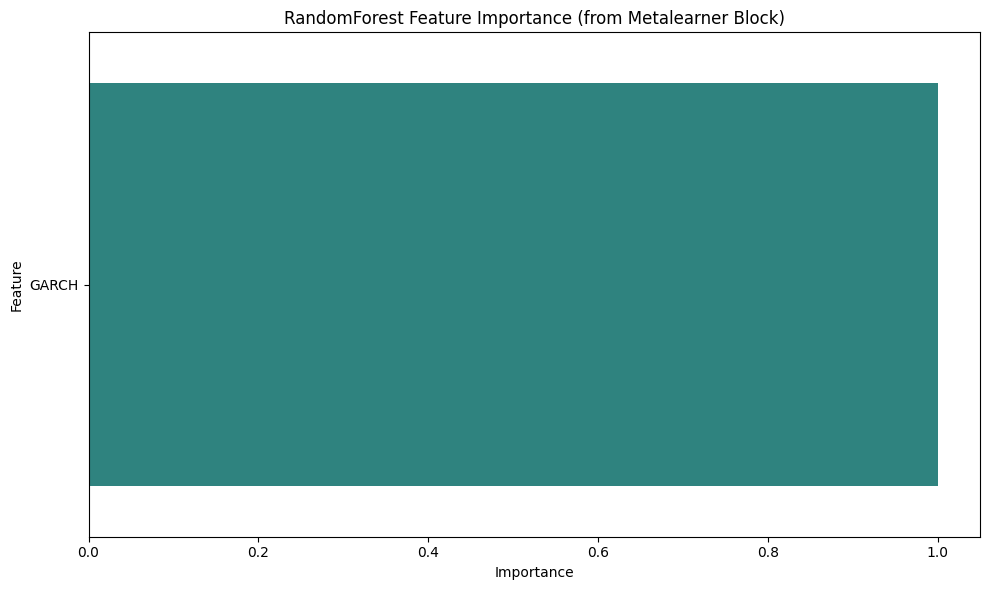

In [38]:
# New Cell: Plot Feature Importances from the RandomForest used in the ensemble

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Retrieve the RandomForest model from the base models dictionary
rf_model = base_models['RandomForest']

# Check if the RandomForest model has the feature_importances_ attribute
if hasattr(rf_model, 'feature_importances_'):
    # Get the feature importances from the model (from its last training iteration)
    rf_importances = rf_model.feature_importances_

    # Create a DataFrame for easy plotting
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot the feature importances using a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title("RandomForest Feature Importance (from Metalearner Block)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("The RandomForest model does not expose feature importances.")


In [47]:
if ML == True:

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.linear_model import LogisticRegression
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, confusion_matrix

    # Define predictors and target using the given column lists.
    # Here, it is assumed that FEATURES contains only one feature (e.g. GARCH predicted volatility).
    predictors = FEATURES
    target = TRUE_REGIME

    # Drop rows with missing values in predictors or target
    data = input_df.dropna(subset=predictors + [target]).reset_index(drop=True)
    X = data[predictors]
    y = data[target]
    # Also grab the DATE column for printing prediction timestamps
    dates = data[DATE]

    # Define the base models suited for one feature.
    base_models = {
        'Logistic': LogisticRegression(max_iter=1000, random_state=42),
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'KNN': KNeighborsClassifier(),
        'LinearSVC': SVC(probability=True, kernel='linear', random_state=42)
    }

    # Define the meta-learner (using logistic regression here)
    meta_learner = LogisticRegression(max_iter=1000, random_state=42)

    window_size = 60  # fixed window length once reached
    min_data_pct = 0.8  # start base model predictions when available data >= 80% of window_size
    base_threshold = int(window_size * min_data_pct)

    # Minimum number of meta training samples required before using the meta learner.
    meta_threshold = 10

    # Initialize dictionaries/lists to store rolling accuracies and meta weights
    rolling_accuracies_base = {name: [] for name in base_models}
    rolling_accuracies_meta = []
    meta_weights_list = []  # record meta-learner coefficients

    # Initialize expanding meta training set (meta features and outcomes)
    meta_train_features = []
    meta_train_targets = []

    print("Starting rolling window evaluation with stacking ensemble (single feature models) and meta learner:")

    for i in range(len(X)):
        # Do not make any prediction until we have at least base_threshold observations
        if i < base_threshold:
            print(f"Skipping prediction for timestamp {dates.iloc[i]} "
                  f"(insufficient data: {i} observations, need {base_threshold}).")
            continue

        # For base models, if i is less than full window_size, use all data from start to i.
        # Once i >= window_size, use a fixed rolling window of size window_size.
        if i < window_size:
            X_train_window = X.iloc[:i]
            y_train_window = y.iloc[:i]
        else:
            X_train_window = X.iloc[i-window_size:i]
            y_train_window = y.iloc[i-window_size:i]

        X_test_window = X.iloc[[i]]
        y_test_window = y.iloc[[i]]
        test_date = dates.iloc[i]

        # --- Step 1: Generate meta features from base model predictions ---
        meta_features_test = np.zeros((1, len(base_models)))
        for j, (name, model) in enumerate(base_models.items()):
            try:
                model.fit(X_train_window, y_train_window)
                probs = model.predict_proba(X_test_window)
                if probs.shape[1] == 1:
                    # Edge-case: model returns only one class probability
                    y_pred_prob = 1.0 if model.classes_[0] == 1 else 0.0
                else:
                    y_pred_prob = probs[0, 1]
            except ValueError as e:
                # If the model fails (for example, insufficient samples in one class), use a default probability.
                print(f"Warning: {e} for model {name} at {test_date}. Using default probability 0.5.")
                y_pred_prob = 0.5

            meta_features_test[0, j] = y_pred_prob

            # Record accuracy for each base model on this test observation.
            try:
                y_pred = model.predict(X_test_window)[0]
            except Exception:
                y_pred = np.nan  # in case prediction fails
            acc = accuracy_score(y_test_window, [y_pred])
            rolling_accuracies_base[name].append(acc)

        # --- Step 2: Use meta training set to make meta prediction once sufficient meta data is available ---
        if i >= window_size and len(meta_train_features) >= meta_threshold:
            meta_learner.fit(np.array(meta_train_features), np.array(meta_train_targets))
            meta_pred = meta_learner.predict(meta_features_test)[0]
            meta_acc = accuracy_score(y_test_window, [meta_pred])
            rolling_accuracies_meta.append(meta_acc)
            meta_weights_list.append(meta_learner.coef_[0])
            prediction_source = "Meta Learner"
            print(f"Test date {test_date}: {prediction_source} Prediction = {meta_pred}, Accuracy = {meta_acc:.2f}")
        else:
            print(f"Test date {test_date}: Base Model predictions only (growing meta training set).")

        # --- Step 3: Append current meta features and true outcome to the expanding meta training set ---
        meta_train_features.append(meta_features_test[0])
        meta_train_targets.append(y_test_window.iloc[0])

    # --- Aggregation of Results ---
    avg_base_acc = {name: np.mean(acc_list) if acc_list else 0 for name, acc_list in rolling_accuracies_base.items()}
    avg_meta_acc = np.mean(rolling_accuracies_meta) if rolling_accuracies_meta else 0
    avg_meta_weights = np.mean(meta_weights_list, axis=0) if meta_weights_list else np.array([])

    results_table = pd.DataFrame({
        'Model': list(avg_base_acc.keys()) + ['Meta Learner'],
        'Average Accuracy': list(avg_base_acc.values()) + [avg_meta_acc]
    })
    print("\nRolling Window Average Accuracies:")
    print(results_table)

    if avg_meta_weights.size > 0:
        weights_table = pd.DataFrame({
            'Base Model': list(base_models.keys()),
            'Average Weight': avg_meta_weights
        })
        print("\nAggregate Meta-Learner Weights (Average Coefficients):")
        print(weights_table)


Starting rolling window evaluation with stacking ensemble (single feature models) and meta learner:
Skipping prediction for timestamp 1963-10-01 00:00:00 (insufficient data: 0 observations, need 48).
Skipping prediction for timestamp 1963-11-01 00:00:00 (insufficient data: 1 observations, need 48).
Skipping prediction for timestamp 1963-12-01 00:00:00 (insufficient data: 2 observations, need 48).
Skipping prediction for timestamp 1964-01-01 00:00:00 (insufficient data: 3 observations, need 48).
Skipping prediction for timestamp 1964-02-01 00:00:00 (insufficient data: 4 observations, need 48).
Skipping prediction for timestamp 1964-03-01 00:00:00 (insufficient data: 5 observations, need 48).
Skipping prediction for timestamp 1964-04-01 00:00:00 (insufficient data: 6 observations, need 48).
Skipping prediction for timestamp 1964-05-01 00:00:00 (insufficient data: 7 observations, need 48).
Skipping prediction for timestamp 1964-06-01 00:00:00 (insufficient data: 8 observations, need 48).


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1967-12-01 00:00:00: Base Model predictions only (growing meta training set).
Test date 1968-01-01 00:00:00: Base Model predictions only (growing meta training set).
Test date 1968-02-01 00:00:00: Base Model predictions only (growing meta training set).


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1968-03-01 00:00:00: Base Model predictions only (growing meta training set).
Test date 1968-04-01 00:00:00: Base Model predictions only (growing meta training set).
Test date 1968-05-01 00:00:00: Base Model predictions only (growing meta training set).


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1968-06-01 00:00:00: Base Model predictions only (growing meta training set).
Test date 1968-07-01 00:00:00: Base Model predictions only (growing meta training set).
Test date 1968-08-01 00:00:00: Base Model predictions only (growing meta training set).
Test date 1968-09-01 00:00:00: Base Model predictions only (growing meta training set).


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1968-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1968-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 1968-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1969-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1969-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1969-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1969-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 1969-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1969-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1969-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1969-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1969-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1969-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1969-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1969-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1970-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1970-02-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1970-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1970-04-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 1970-05-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1970-06-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1970-07-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1970-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1970-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 1970-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1970-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1970-12-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1971-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1971-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1971-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1971-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1971-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1971-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1971-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1971-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1971-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 1971-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1971-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1971-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1972-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1972-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1972-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1973-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1973-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1973-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1973-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1973-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1973-06-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1973-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1973-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1973-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1973-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1973-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1973-12-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1974-01-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1974-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1974-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1974-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1974-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1974-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1974-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1974-08-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1974-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1974-10-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1974-11-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1974-12-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 1975-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1975-02-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 1975-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1975-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1975-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1975-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1975-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1975-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1975-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1975-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1975-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1975-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1976-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1976-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1976-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1977-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1977-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1977-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1977-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1978-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1978-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1978-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1978-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1978-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1978-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1978-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1978-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1978-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1978-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1978-11-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1978-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1979-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1979-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1979-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1979-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1979-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1979-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1979-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1979-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1979-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1979-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1979-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1979-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1980-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1980-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1980-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1980-04-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1980-05-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1980-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1980-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1980-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1980-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1980-10-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1980-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1980-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1981-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1981-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1981-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1981-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1981-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1981-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1981-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1981-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1981-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1981-10-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1981-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1981-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1982-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1982-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1982-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1982-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1982-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1982-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1982-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1982-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1982-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 1982-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1982-11-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1982-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1983-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1983-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1983-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1984-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1984-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1984-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1984-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1984-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1984-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1984-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1984-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1984-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1984-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1984-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1984-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1985-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1985-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1985-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1985-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1986-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1986-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1986-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1986-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1986-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1986-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1986-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1986-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1986-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1986-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1986-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1986-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1987-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1987-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1987-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1987-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1988-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1988-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1988-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1988-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1988-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1988-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1988-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1988-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1988-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1988-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1988-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1988-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1989-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1989-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1989-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1990-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1990-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1990-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1990-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1990-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1990-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1990-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1990-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1990-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1990-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1990-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1990-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1991-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1991-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1991-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1992-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1992-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1992-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1993-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1993-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1993-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1994-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1994-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1994-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1994-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1995-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1995-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1995-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-08-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1996-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 1996-10-01 00:00:00: Meta Learner Prediction = 1.0, Ac

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1996-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1996-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1997-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1997-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1997-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1997-04-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1997-05-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 1997-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1997-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1997-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1997-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1997-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1997-11-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 1997-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1998-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 1998-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1998-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1998-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1999-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 1999-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 1999-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2000-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2000-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2000-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2000-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2000-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2000-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2000-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2000-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2000-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2000-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2000-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2000-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2001-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2001-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2001-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2001-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2001-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2001-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2001-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2001-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2001-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2001-10-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2001-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2001-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2002-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2002-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2002-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2002-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2002-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2002-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2002-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2002-08-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2002-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2002-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2002-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2002-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2003-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2003-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2003-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2003-04-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2003-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2003-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2003-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2003-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2003-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2003-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2003-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2003-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2004-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2004-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2004-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2005-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2005-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2005-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2006-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2006-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2006-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2007-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2007-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2007-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2007-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2008-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2008-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2008-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2008-04-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2008-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2008-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2008-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2008-08-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2008-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2008-10-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2008-11-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2008-12-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2009-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2009-02-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2009-03-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2009-04-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2009-05-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2009-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2009-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2009-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2009-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2009-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2009-11-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2009-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2010-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2010-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2010-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2010-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2010-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2010-06-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2010-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2010-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2010-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2010-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2010-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2010-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2011-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2011-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2011-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2011-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2011-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2011-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2011-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2011-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2011-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2011-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2011-11-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2011-12-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2012-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2012-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2012-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2012-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2012-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2012-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2012-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2012-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2012-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2012-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2012-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Test date 2012-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2013-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2013-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2013-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2014-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2014-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2014-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2015-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2015-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2015-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2015-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2015-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2015-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2015-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2015-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2015-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2015-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2015-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2015-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2016-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2016-02-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2016-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2016-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2016-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2016-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2016-07-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2016-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2016-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2016-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2016-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2016-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2017-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2017-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2017-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2018-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2018-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2018-11-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2018-12-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2019-01-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2019-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2019-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2019-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2019-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2019-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2019-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2019-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2019-09-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2019-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2019-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2019-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2020-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2020-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2020-03-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2020-04-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2020-05-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2020-06-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2020-07-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2020-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2020-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2020-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2020-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2020-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2021-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2021-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2021-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2022-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2022-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2022-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2022-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2022-05-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2022-06-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2022-07-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2022-08-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2022-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2022-10-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 1.00
Test date 2022-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2022-12-01 00:00:00: Meta Learner Prediction = 0.0, Accuracy = 0.00
Test date 2023-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2023-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2023-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2023-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2023-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2023-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2023-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2023-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2023-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2023-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00
Test date 2023-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2023-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-02-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-03-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-04-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-05-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2024-06-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-07-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-08-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-09-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-10-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2024-11-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Test date 2024-12-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00
Test date 2025-01-01 00:00:00: Meta Learner Prediction = 1.0, Accuracy = 1.00

Rolling Window Average Accuracies:
          Model  Average Accuracy
0      Logistic          0.799419
1           LDA          0.837209
2           QDA          0.841570
3  DecisionTree          0.784884
4           KNN          0.821221
5     LinearSVC          0.799419
6  Meta Learner          0.831361

Aggregate Meta-Learner Weights (Average Coefficients):
     Base Model  Average Weight
0      Logistic       -0.214431
1           LDA        2.005758
2           QDA        1.139203
3  DecisionTree        0.077618
4           KNN        0.262769
5     LinearSVC        0.370326


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [39]:
if DL == True:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
    import xgboost as xgb
    from sklearn.metrics import confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Parameters:
    training_window = 120  # Use the previous 120 months as training data
    seq_len = 60           # Generate overlapping sequences of 60 months within the training window
    num_classes = cluster_n  # Regimes are assumed to be labeled 0, 1, 2
    num_features = len(FEATURES)

    all_preds = []   # To store predictions
    all_true = []    # To store true regime labels
    dates_list = []  # To store corresponding dates

    # Ensure data is sorted by date
    data = input_df.sort_values(DATE).reset_index(drop=True)

    # Rolling window: start at index = training_window until end of data
    for i in range(training_window, len(data)):
        # Use the previous 120 months as the training window
        train_window = data.iloc[i - training_window:i].reset_index(drop=True)
        if len(train_window) < training_window:
            continue

        # Generate overlapping sequences of length 60 within the training window
        X_train_sequences = []
        y_train = []
        for j in range(len(train_window) - seq_len + 1):
            seq = train_window[FEATURES].iloc[j : j + seq_len].values
            target = train_window[TRUE_REGIME].iloc[j + seq_len - 1]  # target is the regime at the end of the sequence
            X_train_sequences.append(seq)
            y_train.append(target)
        X_train_sequences = np.array(X_train_sequences)  # shape: (num_samples, seq_len, num_features)
        y_train = np.array(y_train)

        # Build an LSTM feature extractor model using an Input layer
        input_layer = Input(shape=(seq_len, num_features))
        lstm_out = LSTM(32, return_sequences=False)(input_layer)
        dropout_out = Dropout(0.2)(lstm_out)
        feature_extractor = Model(inputs=input_layer, outputs=dropout_out)

        # Extract features from the training sequences
        X_train_features = feature_extractor.predict(X_train_sequences, verbose=0)

        # Train an XGBoost classifier on these features.
        clf = xgb.XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='mlogloss')
        clf.fit(X_train_features, y_train)

        # For prediction, use the last 60-month sequence in the training window
        X_pred_seq = train_window[FEATURES].iloc[-seq_len:].values.reshape(1, seq_len, num_features)
        X_pred_feature = feature_extractor.predict(X_pred_seq, verbose=0)
        pred_regime = clf.predict(X_pred_feature)[0]

        # The true regime for the next month (time index i)
        true_regime = data[TRUE_REGIME].iloc[i]

        all_preds.append(pred_regime)
        all_true.append(true_regime)
        dates_list.append(data[DATE].iloc[i])

        print(f"Prediction for {data[DATE].iloc[i]}: Predicted={pred_regime}, True={true_regime}")

    # Compute overall accuracy
    accuracy = accuracy_score(all_true, all_preds)
    print(f"\nOverall Accuracy: {accuracy*100:.2f}%")

    # Create and visualize the confusion matrix
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Rolling Window Hybrid (LSTM + XGBoost) Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [61]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Read the Excel file and parse the target sheet "22.2.2025"
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
excel_df = xls_file.parse("22.2.2025")

# Ensure the Date column is in datetime format
excel_df['Date'] = pd.to_datetime(excel_df['Date'])

# Merge the predictions into the original DataFrame on the Date column
merged_df = excel_df.merge(predictions_df, on='Date', how='left')

# Sort the DataFrame by Date (optional)
merged_df = merged_df.sort_values('Date').reset_index(drop=True)

# Create a new workbook and set the active sheet title to "data"
new_wb = Workbook()
ws = new_wb.active
ws.title = "data"

# Write the merged DataFrame to the new sheet
for r in dataframe_to_rows(merged_df, index=False, header=True):
    ws.append(r)

# Save the new workbook
new_wb.save("data+regimes.xlsx")
